In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# 1. Load and clean your data
train_data = pd.read_csv('Google_Stock_Price_Train.csv', date_format=True)
test_data = pd.read_csv('Google_Stock_Price_Test.csv', date_format=True)
'''
# Clean the data by removing commas and converting to float
def clean_data(data):
    for col in data.columns:
        if data[col].dtype == 'object':  # Check if the column is of string type
            data[col] = data[col].str.replace(',', '').astype(float)
    return data
'''
# Clean the data by removing commas and converting only numeric columns to float
def clean_data(data):
    for col in data.select_dtypes(include=['object']).columns:
        if col != 'Date':  # Skip the Date column or any non-numeric columns
            data[col] = data[col].str.replace(',', '').astype(float)
    return data

train_data = clean_data(train_data)
test_data = clean_data(test_data)

In [5]:
# 2. Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))
test_scaled = scaler.transform(test_data['Close'].values.reshape(-1, 1))


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Assuming original_df contains all features: 'Open', 'High', 'Low', 'Close', 'Volume'
features = ['Open', 'High', 'Low', 'Close', 'Volume']
scaler = MinMaxScaler()

# Fit and transform the data to scale all features
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(test_data[features])

print("train_scaled shape:", train_scaled.shape)
print("test_scaled shape:", test_scaled.shape)


train_scaled shape: (1258, 5)
test_scaled shape: (20, 5)


In [9]:
print("train_scaled shape:", train_scaled.shape)
print("test_scaled shape:", test_scaled.shape)


train_scaled shape: (1258, 5)
test_scaled shape: (20, 5)


In [7]:
# 3. Create sequences for LSTM
sequence_length = 10  # Number of days used for prediction

print("X_test shape before reshape:", test_scaled.shape)
'''
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)
'''
column_names = ['Open', 'High', 'Low', 'Close', 'Volume']

train_df = pd.DataFrame(train_scaled, columns=features)
test_df = pd.DataFrame(test_scaled, columns=features)


def create_sequences(df, target_column, sequence_length):
    X, y = [], []
    
    # Extract features (X) and target (y)
    features = df.drop(columns=[target_column]).values  # Drop target column
    target = df[target_column].values
    
    # Loop over the data and target to create sequences
    for i in range(len(df) - sequence_length):
        X.append(features[i:i + sequence_length])  # Sequence of inputs (X)
        y.append(target[i + sequence_length])  # The target value after the sequence (y)
        
    return np.array(X), np.array(y)


'''
# Apply to test set
X_test_sequences = create_sequences(X_test, sequence_length)
print("X_test_sequences shape:", X_test_sequences.shape)
'''
'''
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
'''
X_train, y_train = create_sequences(train_df, target_column='Close', sequence_length=sequence_length)
X_test, y_test = create_sequences(test_df, target_column='Close', sequence_length=sequence_length)

#print("X_test shape before reshape:", X_test.shape)


# Check if X_test has at least two dimensions
if len(X_test.shape) < 2:
    raise ValueError(f"X_test does not have the correct shape for reshaping: {X_test.shape}")

# Check the shape of the data
print("X_train shape after sequencing:", X_train.shape)
print("X_test shape after sequencing:", X_test.shape)

'''
# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
'''

# Check the shape of the data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_test shape before reshape: (20, 5)
X_train shape after sequencing: (1248, 10, 4)
X_test shape after sequencing: (10, 10, 4)
X_train shape: (1248, 10, 4)
X_test shape: (10, 10, 4)


In [45]:
y_train.shape

(1248,)

In [9]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"X_train_split shape: {X_train_split.shape}")
print(f"X_val_split shape: {X_val_split.shape}")


X_train_split shape: (998, 10, 4)
X_val_split shape: (250, 10, 4)


In [11]:
# 4. Define the objective function for Optuna optimization
def objective(trial):
    lstm_units = trial.suggest_int('lstm_units', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 10, 150)

    # Build the model
    model = Sequential([
        Input(shape=(X_train_split.shape[1], X_train_split.shape[2])),  # Define input shape
        LSTM(lstm_units, activation='tanh', return_sequences=False),
        Dropout(dropout_rate),
        Dense(1)  # Predicting the next day's value
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    # Add EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), 
                        epochs=epochs, batch_size=batch_size, 
                        callbacks=[early_stopping], verbose=0)

    # Return validation loss as the objective to minimize
    return history.history['val_loss'][-1]

In [13]:
# 5. Create Optuna study and optimize the objective
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Run for 20 trials

# Print best parameters
print(f"Best Hyperparameters: {study.best_params}")

[I 2024-12-07 03:09:49,485] A new study created in memory with name: no-name-880edf88-07f6-44b1-87c1-6e61cfbfa3dc
[I 2024-12-07 03:09:52,978] Trial 0 finished with value: 0.013890579342842102 and parameters: {'lstm_units': 81, 'learning_rate': 0.003123362842649988, 'dropout_rate': 0.20789487704231707, 'batch_size': 32, 'epochs': 96}. Best is trial 0 with value: 0.013890579342842102.
[I 2024-12-07 03:09:55,897] Trial 1 finished with value: 0.023561391979455948 and parameters: {'lstm_units': 140, 'learning_rate': 0.0015657721074764596, 'dropout_rate': 0.21720592312024423, 'batch_size': 64, 'epochs': 88}. Best is trial 0 with value: 0.013890579342842102.
[I 2024-12-07 03:09:59,034] Trial 2 finished with value: 0.025317879393696785 and parameters: {'lstm_units': 146, 'learning_rate': 0.0012285791420729548, 'dropout_rate': 0.25811391514125326, 'batch_size': 32, 'epochs': 146}. Best is trial 0 with value: 0.013890579342842102.
[I 2024-12-07 03:10:02,311] Trial 3 finished with value: 0.015852

Best Hyperparameters: {'lstm_units': 98, 'learning_rate': 0.009629301314589427, 'dropout_rate': 0.3806911615573982, 'batch_size': 16, 'epochs': 76}


In [15]:
# 6. Train the final model using the best hyperparameters
best_params = study.best_params
lstm_units = best_params['lstm_units']
learning_rate = best_params['learning_rate']
dropout_rate = best_params['dropout_rate']
batch_size = best_params['batch_size']
epochs = best_params['epochs']

final_model = Sequential([
    Input(shape=(X_train_split.shape[1], X_train_split.shape[2])),  # Define input shape
    LSTM(lstm_units, activation='tanh', return_sequences=False),
    Dropout(dropout_rate),
    Dense(1)
])

final_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

# Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = final_model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split),
                          epochs=epochs, batch_size=batch_size,
                          callbacks=[early_stopping], verbose=1)


Epoch 1/76
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0856 - mae: 0.2120 - val_loss: 0.0399 - val_mae: 0.1523
Epoch 2/76
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0475 - mae: 0.1658 - val_loss: 0.0424 - val_mae: 0.1737
Epoch 3/76
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0468 - mae: 0.1660 - val_loss: 0.0330 - val_mae: 0.1349
Epoch 4/76
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0371 - mae: 0.1439 - val_loss: 0.0364 - val_mae: 0.1477
Epoch 5/76
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0310 - mae: 0.1239 - val_loss: 0.0313 - val_mae: 0.1236
Epoch 6/76
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 - mae: 0.1186 - val_loss: 0.0236 - val_mae: 0.0999
Epoch 7/76
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0294 - mae: 0.1107 - val_loss: 0.0314 - val_mae: 0.1160
Epoch 8/76
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261 - mae: 0.1038 - val_loss: 0.0256 - val_mae: 0.1016
Epoch 9/76
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274 - mae: 

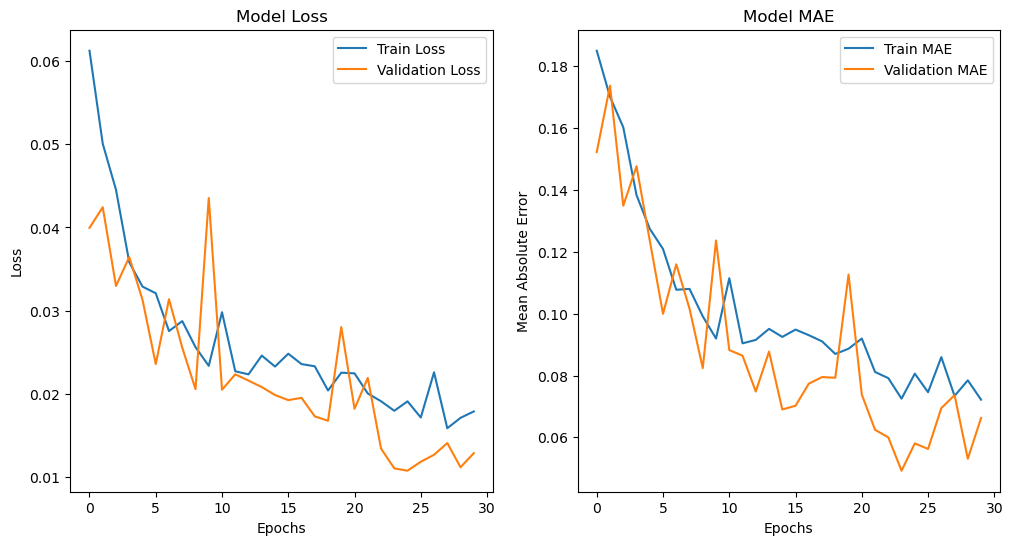

In [37]:
# 7. Visualize training/validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()


In [ ]:
'''
# Reshape y_test to have 5 columns (similar to the shape the scaler was fitted on)
y_test_full = np.hstack([X_test, y_test.reshape(-1, 1)])  # Add the other features to y_test

# Now, inverse transform the entire data
y_test_actual_full = scaler.inverse_transform(y_test_full)

# Extract only the target column (e.g., 'Close') from the result
y_test_actual = y_test_actual_full[:, -1]  # Assuming 'Close' is the last column
'''

In [29]:
X_test.shape

(10, 10, 4)

In [47]:
# 8. Make predictions with the trained model
y_pred = final_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [49]:
y_pred.shape

(10, 1)

In [51]:
y_test.shape

(10,)

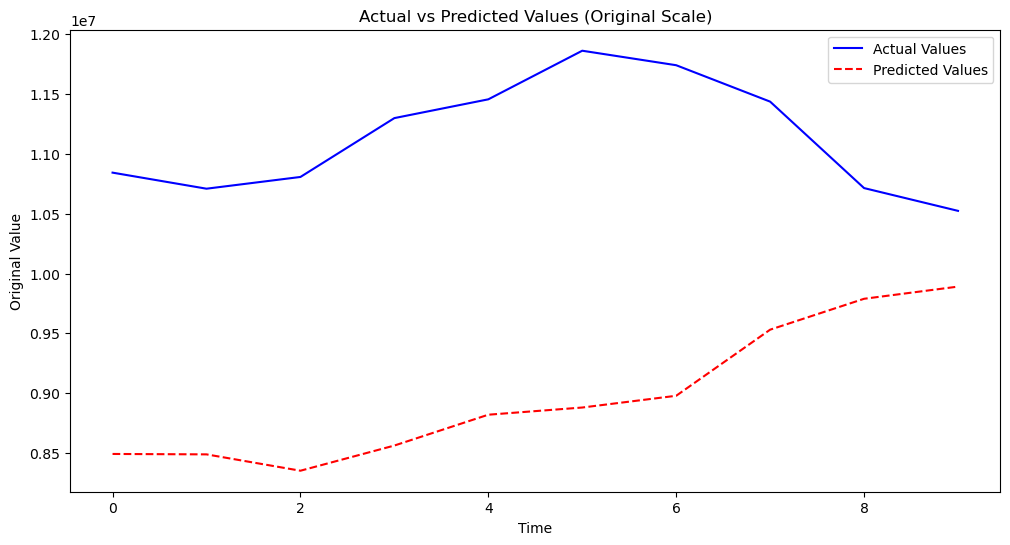

In [69]:
# Reshape y_test and y_pred to be of shape (10, 1)
y_test_reshaped = y_test.reshape(-1, 1)  # Shape: (10, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)  # Shape: (10, 1)

# Combine y_test_reshaped with dummy features to match the 5 features (X_test has 5)
# We create a dummy array with 4 features (using np.zeros) and combine it with y_test_reshaped
dummy_features = np.zeros((y_test_reshaped.shape[0], 4))  # 4 dummy features (columns)
combined_test = np.hstack([dummy_features, y_test_reshaped])  # Shape: (10, 5)

# Inverse transform the combined data (X_test + y_test) using the scaler
combined_test_actual = scaler.inverse_transform(combined_test)

# Extract the actual target values (y_test) from the combined data
y_test_actual = combined_test_actual[:, -1]  # The last column is the target

# Repeat the same for y_pred
combined_pred = np.hstack([dummy_features, y_pred_reshaped])  # Combine with dummy features
combined_pred_actual = scaler.inverse_transform(combined_pred)

# Extract the predicted target values (y_pred)
y_pred_actual = combined_pred_actual[:, -1]

# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Values", color='blue')
plt.plot(y_pred_actual, label="Predicted Values", color='red', linestyle='--')
plt.title("Actual vs Predicted Values (Original Scale)")
plt.xlabel("Time")
plt.ylabel("Original Value")
plt.legend()
plt.show()


In [75]:
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
print(f'MAPE: {mape}%')


MAPE: 19.229203220384385%
